<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Fraude_CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de fraudes à la carte bancaire

Cette base de données contient des transactions effectuées par CB en septembre 2013 par des utilisateurs européens. Les données ont été enregistrées sur deux jours, pendant lesquels 492 utilisations frauduleuses sur un total de 284 807 transactions ont été enregistrées.  

Ce ratio est fortement déséquilibré car les cas de fraudes ne représentent que 0.172% des transactions. Un apprentissage supervisé n'est donc pas possible ici.  

Nous allons utiliser un auto-encodeur pour effectuer un apprentissage non supervisé afin de détecter des irrégularités dans les données, indices de fraudes.  

Les données sont disponibles sur le site de [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Lecture des données

Le nombre de données est très grand. Pour réduire le temps de calcul, nous n'utiliserons qu'une partie d'entre elles.  

In [2]:
!wget -q "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip"
!unzip creditcard.zip -x

Archive:  creditcard.zip
  inflating: creditcard.csv          


In [ ]:
!ls

creditcard.csv	creditcard.zip	sample_data


In [3]:
data = pd.read_csv("creditcard.csv")
data = data.head(30000)
data.shape

(30000, 31)

Les colonnes qui ne sont pas anonymisées sont :
- Time : Temps écoulé depuis la première transaction
- Amount : Montant de la transaction
- Class : 0 = Achat non frauduleux / 1 = achat frauduleux
  
Les autres données anonymes sont par exemple les coordonnées de l'acheteur, son adresse, ...

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.313255,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.346564,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.341805,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.195958,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.044340,0


Regardons combien nous avons de données frauduleuses :

In [ ]:
data.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906
1,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94


In [ ]:
100*(94/29906)

0.31431819701732094

## Préparation des données

La colonne Time est ignorée et le montant de la transaction est normalisé. Les autres colonnes sont inchangées

In [4]:
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [5]:
x_entrainement, x_test = train_test_split(data, test_size=0.2, random_state=0)
x_entrainement = x_entrainement.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_entrainement = x_entrainement.values
x_test = x_test.values
x_entrainement.shape

(24000, 29)

## Construction du modèle

Ce modèle est un modèle standard d'auto-encodeur à quatre couches :
- Une couche d'entrée à 14 neurones, avec une fonction d'activation de type tanh
- Une première couche cachées de 14/2 = 7 neurones, avec une fonction d'activation de type relu
- Une deuxième couche cachée de 14/2 = 7 neurones, avec une fonction d'activation de type tanh
- Une couche de sortie à 14 neurones, avec une fonction d'activation de type relu

In [6]:
dimension_entrees = x_entrainement.shape[1]
dimension_encodeur = 14

model = Sequential()
model.add(Dense(dimension_encodeur, activation="tanh", input_shape=(dimension_entrees,)))
model.add(Dense(int(dimension_encodeur /2), activation="relu"))
model.add(Dense(int(dimension_encodeur /2), activation='tanh'))
model.add(Dense(dimension_entrees, activation='relu'))28

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


# Entrainement du modèle



In [7]:
nb_iterations = 40
batch_size = 35

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_entrainement, x_entrainement,
                    epochs=nb_iterations,
                    batch_size=batch_size,
                    validation_data=(x_test, x_test),
                    verbose=1)

autoencoder = model

Epoch 1/40
686/686 [==============================] - 2s 2ms/step - loss: 1.2159 - acc: 0.1864 - val_loss: 0.9698 - val_acc: 0.4233
Epoch 2/40
686/686 [==============================] - 1s 2ms/step - loss: 1.0093 - acc: 0.4370 - val_loss: 0.9268 - val_acc: 0.4910
Epoch 3/40
686/686 [==============================] - 1s 2ms/step - loss: 1.0290 - acc: 0.5039 - val_loss: 0.9024 - val_acc: 0.5143
Epoch 4/40
686/686 [==============================] - 1s 2ms/step - loss: 0.8672 - acc: 0.5254 - val_loss: 0.8826 - val_acc: 0.5612
Epoch 5/40
686/686 [==============================] - 1s 2ms/step - loss: 0.8736 - acc: 0.5732 - val_loss: 0.8660 - val_acc: 0.6037
Epoch 6/40
686/686 [==============================] - 1s 2ms/step - loss: 0.9467 - acc: 0.6135 - val_loss: 0.8547 - val_acc: 0.6273
Epoch 7/40
686/686 [==============================] - 1s 2ms/step - loss: 0.9399 - acc: 0.6429 - val_loss: 0.8454 - val_acc: 0.6478
Epoch 8/40
686/686 [==============================] - 1s 2ms/step - loss: 0.

## Performances du modèle


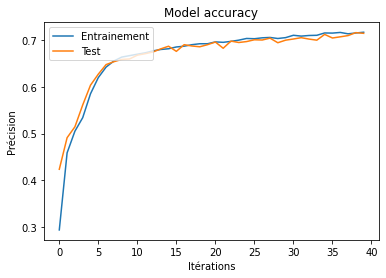

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [ ]:
x_test

## Structure du modèle
La structure de notre modèle peut être visualisée comme ci-dessous :  
![picture](https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Schema_Non_Supervis%C3%A9.png?raw=true "ReseauNeurone")

## Prédictions

Les prédictions sont effectuées sur les données de tests. L'erreur quadratique moyenne (mean-suqared error - MSE) est calculés entre les tests et les prédictions. Si cette erreur est grande, c'est une potentielle anomalie et donc une fraude potentielle. Bien sûr, cela n'est pas parfait et il y a des faux-positifs !

In [ ]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [ ]:
error_df.head()

## Affichage de l'erreur de reconstruction

The reconstruction error for each sample is plotted long with a color code indicating known fraud. Only 6000 samples are plotted, but the index is randomly sampled from the original set, so the X-axis shows almost the full range of indices.

In [ ]:
threshold = 6.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Analyse

Comme nous connaissons les transactions frauduleuses, nous pouvons afficher et calculer le nombre de faux positifs. Dans l'idéal, il faudrait que leur nombre soit très faible, mais notre modèle est imparfait... 

In [ ]:
normal = error_df[error_df.true_class == 0]
fraud = error_df[error_df.true_class == 1]

print('Normal transactions: %d, fraud transactions: %d' % (len(normal), len(fraud)))

Normal transactions: 5984, fraud transactions: 16


In [ ]:
true_positives = len(fraud[fraud.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(fraud[fraud.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 10, true negatives: 5925
False positives: 59, false negatives: 6


## Confusion Matrix

The confusion matrix below shows the number of true/false positive/negatives. It's not perfect, but not too bad either.

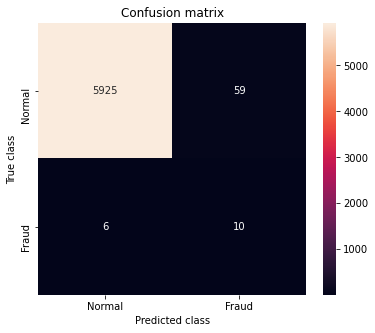

In [ ]:
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()